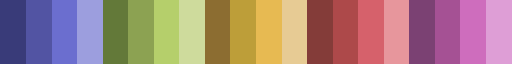

In [50]:
from importlib import reload
import script_util
reload(script_util)
from script_util import root, rcParams, cmap
from typing import *
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

plt.rcParams.update(rcParams)

unit = 1
cmap

In [58]:
B = 4
master = {
    "v3-mirror-auto4-noaug":{
        "paths":[root/"training116/00013-v3-mirror-auto4-noaug"],
        "color": cmap(0*B+0),
        "linestyle": "solid",
        "label": "背景白で腰上の立ち絵,2万枚,augなし",
    },
    "v3-mirror-auto4-bg":{
        "paths": [root/"training115/00009-v3-mirror-auto4-bg", root/"training115/00010-v3-mirror-auto4-bg-resumecustom", root/"training116/00014-v3-mirror-auto4-bg-resumecustom"],
        "color": cmap(0*B+3),
        "linestyle": "dashed",
        "label": "背景白で腰上の立ち絵,2万枚,augはbitblit+geometry",
    },
    "v4-mirror-auto4-noaug":{
        "paths":[root/"training116/00015-v4-mirror-auto4-noaug"],
        "color": cmap(1*B+0),
        "linestyle": "solid",
        "label": "背景白で腰上の立ち絵,8万枚,augなし",
    },
    "v4-mirror-auto4-bg":{
        "paths":[root/"training116/00016-v4-mirror-auto4-bg"],
        "color": cmap(1*B+3),
        "linestyle": "dashed",
        "label": "背景白で腰上の立ち絵,8万枚,augはbitblit+geometry",
    },
    "portraits-mirror-auto4-noaug":{
        "paths":[root/"training116/00009-portraits-mirror-auto4-noaug"],
        "color": cmap(2*B+0),
        "linestyle": "solid",
        "label": "顔アップ,30万枚,augなし",
    },
    "portraits-mirror-auto4":{
        "paths":[root/"training116/00010-portraits-mirror-auto4"],
        "color": cmap(2*B+2),
        "linestyle": "dashed",
        "label": "顔アップ,30万枚,augはbitblit+geometry+color",
    },
    "portraits-mirror-auto4-target0.8-bg":{
        "paths":[root/"training115/00014-portraits-mirror-auto4-target0.8-bg"],
        "color": cmap(2*B+3),
        "linestyle": "dashdot",
        "label": "顔アップ,30万枚,augはbg,target=0.8",
    },
    "white_yc05_yw04-mirror-auto4-noaug":{
        "paths":[root/"training116/00018-white_yc05_yw04-mirror-auto4-noaug"],
        "color": cmap(3*B+0),
        "linestyle": "solid",
#        "label": "顔アップ(v4),8万枚,augなし",
    },
    "white_yc05_yw04-mirror-auto4-target0.7-bg":{
        "paths":[root/"training116/00020-white_yc05_yw04-mirror-auto4-target0.7-bg"],
        "color": cmap(3*B+3),
        "linestyle": "dashdot",
#        "label": "顔アップ(v4),8万枚,augなし",
    },
}

In [59]:
class Result(NamedTuple):
    path: Path
    metric: Dict[str, Any]

class Results:
    def __init__(self, paths, metric="fid50k_full"):
        self.results = list()
        self.metric = metric
        for i, path in enumerate(paths):
            for j, line in enumerate((path/f"metric-{self.metric}.jsonl").read_text().strip().split("\n")):
                if i != 0 and j == 0: continue
                metric = json.loads(line)
                self.results.append(Result(path, metric))
    def __len__(self):
        return len(self.results)
    def metric_list(self):
        return [metric["results"][self.metric] for path, metric in self.results]
    def image(self, i):
        path, metric = self.results[i]
        num = metric["snapshot_pkl"].split("-")[-1].split(".")[0]
        return path/f"fakes{num}.png"

In [60]:
def myplot(names: List[str], best=1, metric="fid50k_full"):
    fig, ax = plt.subplots()
    maxX = 0
    maxY = 0
    minY = float("inf")
    for name in names:
        results = Results(master[name]["paths"], metric=metric)
        Y = results.metric_list()
        X = [unit*i for i in range(len(Y))]
        maxX = max(maxX, max(X))
        maxY = max(maxY, max(Y))
        minY = min(minY, min(Y))
        YX = list(zip(Y, X))
        YX.sort()
        bests = set()
        for i in range(best):
            y, x = YX[i]
            bests.add(y)
#            ax.text(x, 40*y-1200, f"{y:.1f}\n{str(results.image(x))}", color=master[name]["color"])
#            ax.text(x, y-50, f"{y:.1f}\n{x}", color=master[name]["color"])
            ax.text(x, y-minY, f"{y:.0f}", color=master[name]["color"])
            plt.scatter([x], [y], lw=1, marker="x", color=master[name]["color"])
        plt.plot(
            X, Y,
            lw=1, marker="",
            label=master[name].get("label", name),
            color=master[name].get("color", cmap(0)),
            linestyle=master[name].get("linestyle", "solid")
        )

    ax.set_xticks([x for x in range(int(maxX)) if x%10 == 0])
    ax.set_xticks([x for x in range(int(maxX)) if x%2 == 0], minor=True)
    ax.set_yticks([y for y in range(int(maxY)) if y%10 == 0], minor=True)
    ax.grid(which="major", alpha=0.6)
    ax.grid(which="minor", alpha=0.2)
    plt.xlabel("*200kimg")
    plt.ylabel(metric)
    plt.legend()

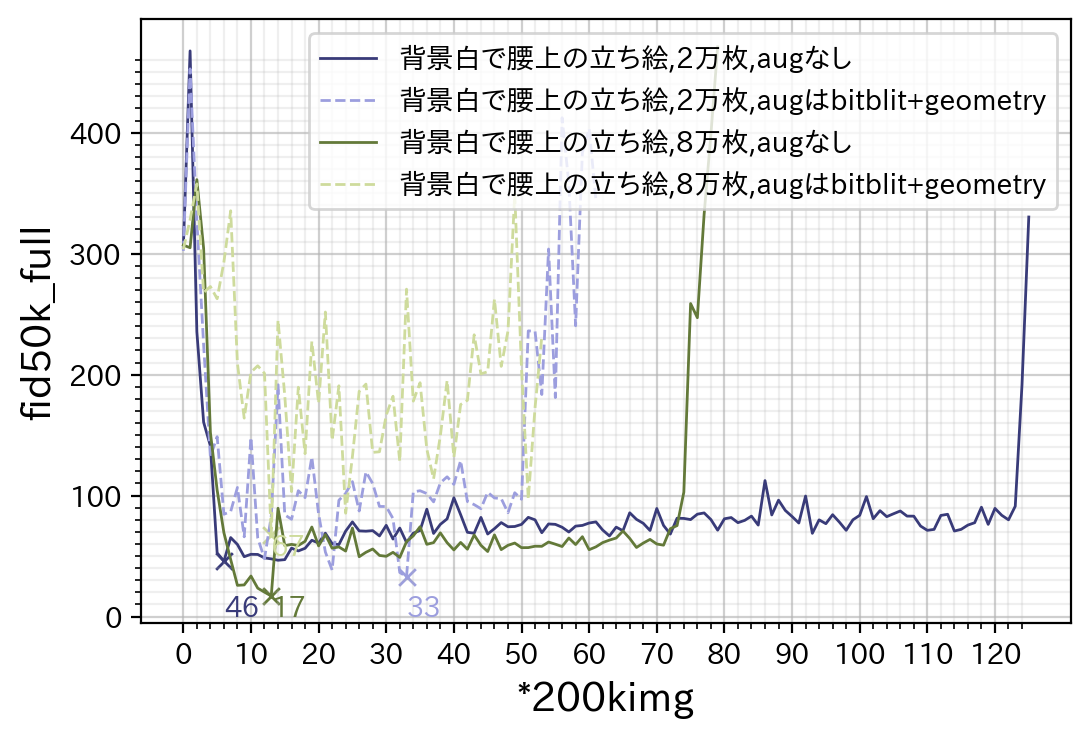

In [61]:
myplot([
    "v3-mirror-auto4-noaug",
    "v3-mirror-auto4-bg",
    "v4-mirror-auto4-noaug",
    "v4-mirror-auto4-bg",
])

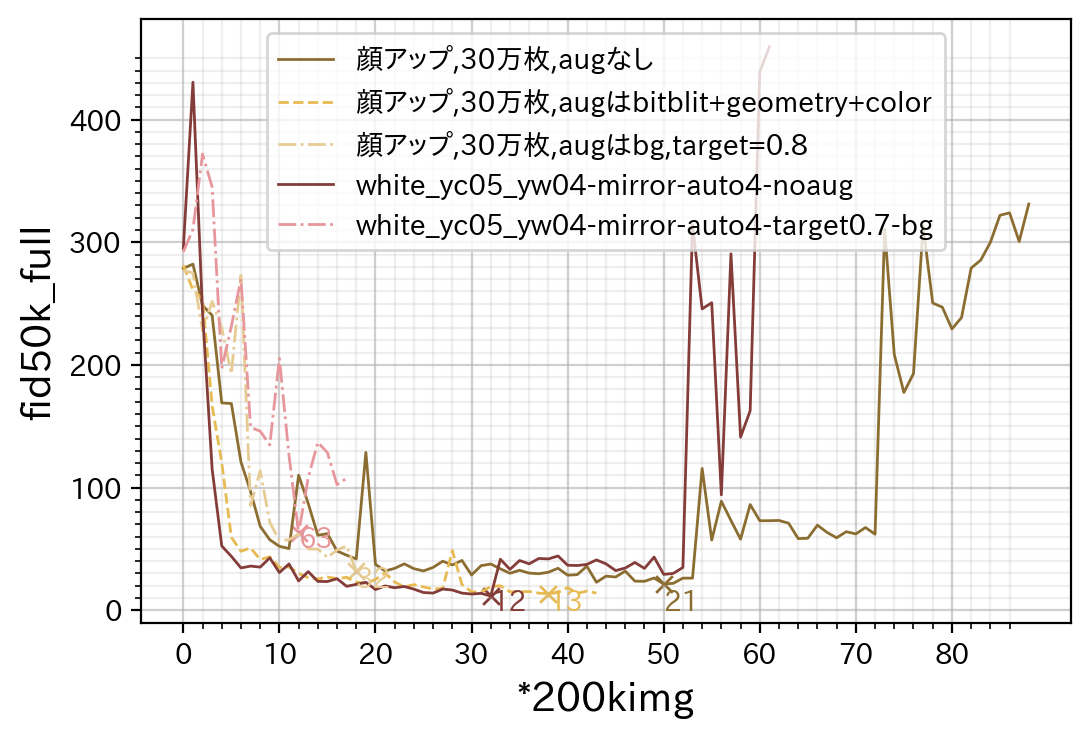

In [65]:
myplot([
    "portraits-mirror-auto4-noaug",
    "portraits-mirror-auto4",
    "portraits-mirror-auto4-target0.8-bg",
    "white_yc05_yw04-mirror-auto4-noaug",
    "white_yc05_yw04-mirror-auto4-target0.7-bg",
])

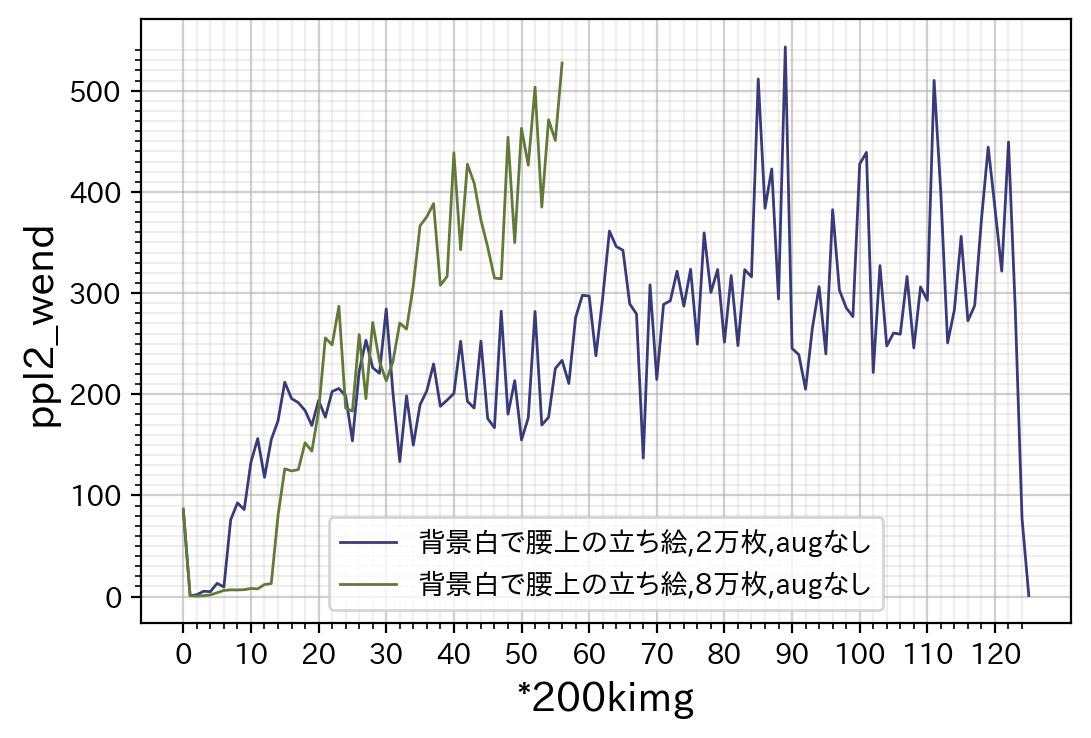

In [63]:
myplot(["v3-mirror-auto4-noaug", "v4-mirror-auto4-noaug"], metric="ppl2_wend", best=0)

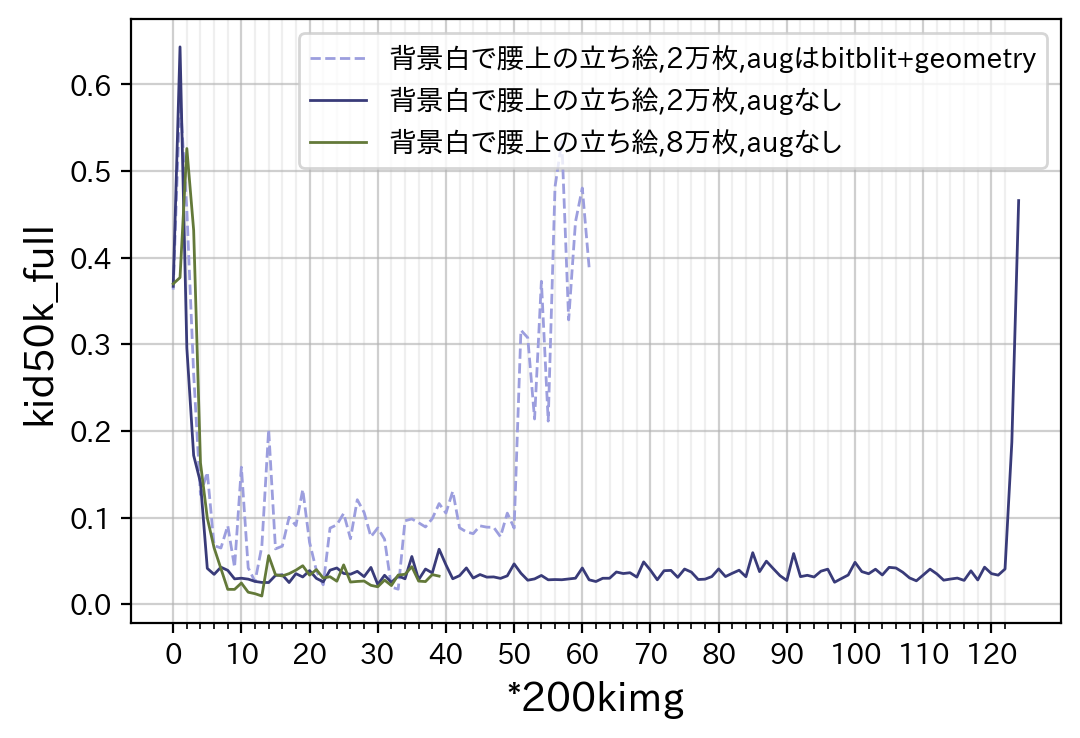

In [64]:
myplot(["v3-mirror-auto4-bg","v3-mirror-auto4-noaug", "v4-mirror-auto4-noaug"], metric="kid50k_full", best=0)